In [1]:
import process as pc
import detection as dt
import dataset as ds
from IPython.core.interactiveshell import InteractiveShell

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import joblib
import cv2

import numpy as np

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

In [2]:
def print_image(image, keypoints):
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)
    for kp in keypoints:
        rect = patches.Rectangle((kp[0]-40, kp[1]-40), kp[0]+40, kp[1]+40, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show();

In [3]:
pipeline_save_path = ds.DATA_PATH+"/hog_new_dataset.pkl"
image_path = ds.DATA_PATH+"/final/amadeus.jpg"
#image_path =ds.DATA_PATH+"/real_faces_128/073425.jpg"

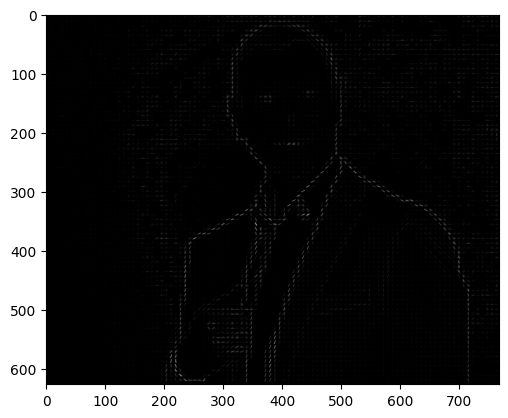

In [4]:
from skimage.feature import hog
image = cv2.imread(image_path)
image = cv2.resize(image, (int(image.shape[1]*0.75), int(image.shape[0]*0.75)))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.equalizeHist(image)
#image = pc.process_image(image, resize=True, img_resize=(int(image.shape[1]*0.75), int(image.shape[0]*0.75)))
features, hog_img = hog(image, visualize=True)
plt.imshow(hog_img, cmap='gray');

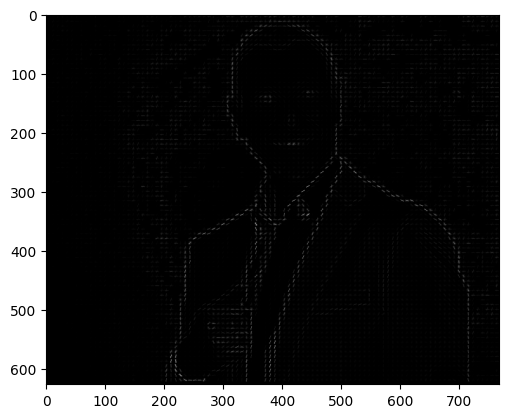

In [7]:
image = cv2.imread(image_path)
image = pc.process_image(image, resize=True, img_resize=(int(image.shape[1]*0.75), int(image.shape[0]*0.75)))
features, hog_img = hog(image, visualize=True)
plt.imshow(hog_img, cmap='gray');

In [6]:
image = cv2.imread(image_path)
pipeline = joblib.load(pipeline_save_path)
keypoints, _ = dt.detect_faces(image, pipeline, method='HOG', threshold=0.6, window_size=(96, 96), step_size=(64,64),\
                                n_keypoints=8100, resize=True, image_size=(int(image.shape[1]*0.75), int(image.shape[0]*0.75)),\
                                     preprocess=False, verbose=True, notebook=True)
keypoints

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] [0.03352954 0.01234706 0.03389972 0.03929547 0.05932533 0.05080176
 0.14024669 0.09568686 0.07878794 0.14382937 0.09969032 0.05466399
 0.0213444  0.05459029 0.01316394 0.08012632 0.21659681 0.07593383
 0.09398541 0.05576024 0.03954489 0.0765169  0.03388343 0.01491812
 0.02478715 0.02107835 0.03348472 0.22558915 0.13499435 0.06004803
 0.01210402 0.02204929 0.04017896 0.03071511 0.03319188 0.05630778
 0.03036518 0.05980595 0.04741654 0.1472662  0.08739814 0.09176806
 0.02276947 0.05354568 0.03389378 0.0313264  0.0323182  0.02491462
 0.05757865 0.14061665 0.37366933 0.06706113 0.08432462 0.10248268
 0.04867161 0.02457144 0.03552368 0.01845978 0.02837561 0.08739561
 0.2415517  0.14483398 0.24

array([], dtype=float64)

In [ ]:
print_image(image, keypoints)